In [1]:
%matplotlib widget

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt

from tqdm import tqdm

from pyinverse.angle import Angle, AngleRegularAxis
from pyinverse.axis import RegularAxis
from pyinverse.grid import RegularGrid
from pyinverse.axes import RegularAxes3
from pyinverse.phantom3 import Phantom3
from pyinverse.fbp3 import ramp_filter3, backproject3, fbp3_theta0

from pyviz3d.viz import Renderer

In [3]:
#Nx = 46
#Ny = 47
#Nz = 48
# Nx = 127
# Ny = 128
# Nz = 129
Nx = 255
Ny = 256
Nz = 257
axes3 = RegularAxes3.linspace((-1, 1, Nx), (-1, 1, Ny), (-1, 1, Nz))

In [4]:
Nu = 512
Nv = 513
#grid_uv = RegularGrid.linspace((-1.5, 1.5, Nu), (-1.5, 1.5, Nv))
grid_uv = RegularGrid.linspace((-2, 2, Nu), (-2, 2, Nv))

In [5]:
# trivial geometry (via Clack 1992) is with theta = 0
#theta = Angle(deg=-90)
theta = Angle(deg=0)

phi = Angle(deg=0)

In [6]:
p3 = Phantom3()

In [7]:
p3._ellipsoids[0].alpha

<Angle deg=0.0 rad=0.0>

In [8]:
p_uv = p3.proj(theta, phi, grid_uv)

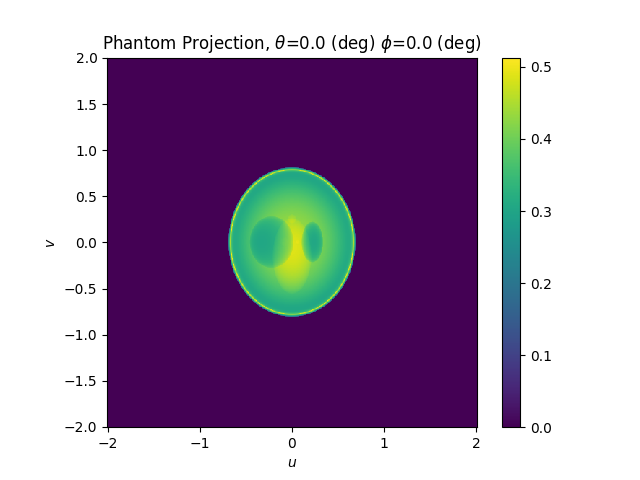

In [9]:
fig, ax = plt.subplots()
im = grid_uv.plot(ax, p_uv)
ax.set_xlabel(f'$u$')
ax.set_ylabel(f'$v$')
ax.set_title(f'Phantom Projection, $\\theta$={theta.deg} (deg) $\phi$={phi.deg} (deg)')
plt.colorbar(im, ax=ax);

In [10]:
grid_uv_ft, p_uv_ft = grid_uv.spectrum(p_uv)
grid_uv_ft

<FreqRegularGrid <axis_x: <FFTRegularAxis x0=-401.3384614960961 T=1.5677283652191254 N=512>> <axis_y: <FFTRegularAxis x0=-401.339992486668 T=1.5677343456510469 N=513>>>

In [11]:
grid_uv_ft_Hz = grid_uv_ft.Hz()
grid_uv_ft_Hz

<RegularGrid <axis_x: <FFTRegularAxis x0=-63.875 T=0.24951171875 N=512>> <axis_y: <FFTRegularAxis x0=-63.875243664717345 T=0.24951267056530213 N=513>>>

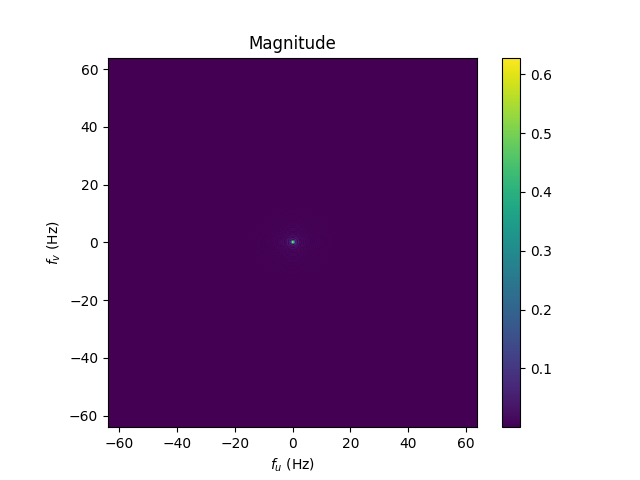

In [12]:
fig, ax = plt.subplots()
im = grid_uv_ft_Hz.plot(ax, np.abs(p_uv_ft))
ax.set_xlabel(f'$f_u$ (Hz)')
ax.set_ylabel(f'$f_v$ (Hz)')
ax.set_title('Magnitude')
plt.colorbar(im, ax=ax);

In [13]:
ramp = ramp_filter3(grid_uv_ft_Hz)

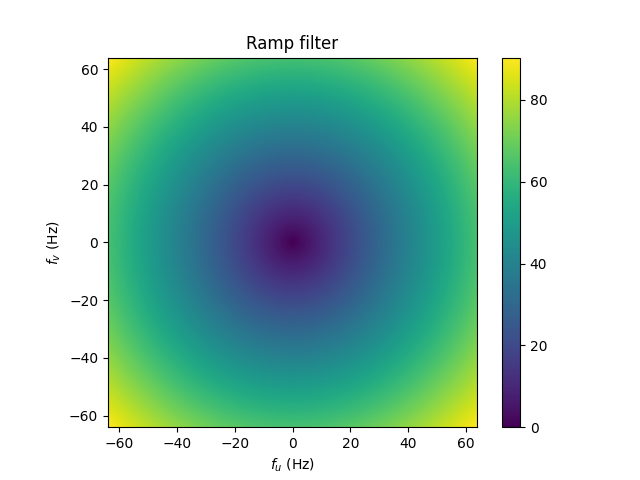

In [14]:
fig, ax = plt.subplots()
im = grid_uv_ft_Hz.plot(ax, ramp)
ax.set_xlabel(f'$f_u$ (Hz)')
ax.set_ylabel(f'$f_v$ (Hz)')
ax.set_title('Ramp filter')
plt.colorbar(im, ax=ax);

In [15]:
p_uv_ft_ramp = p_uv_ft * ramp

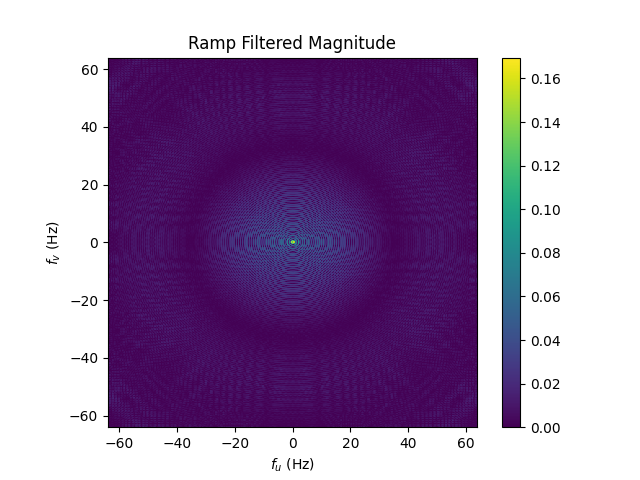

In [16]:
fig, ax = plt.subplots()
im = grid_uv_ft_Hz.plot(ax, np.abs(p_uv_ft_ramp))
ax.set_xlabel(f'$f_u$ (Hz)')
ax.set_ylabel(f'$f_v$ (Hz)')
ax.set_title('Ramp Filtered Magnitude')
plt.colorbar(im, ax=ax);

In [17]:
check, p_uv_filtered = grid_uv_ft.ispectrum(p_uv_ft_ramp)
check, grid_uv

(<RegularGrid <axis_x: <RegularAxis x0=-2 T=0.007827788649706457 N=512>> <axis_y: <RegularAxis x0=-2 T=0.0078125 N=513>>>,
 <RegularGrid <axis_x: <RegularAxis x0=-2 T=0.007827788649706457 N=512>> <axis_y: <RegularAxis x0=-2 T=0.0078125 N=513>>>)

In [18]:
assert np.allclose(np.imag(p_uv_filtered), 0)
p_uv_filtered = np.real(p_uv_filtered)

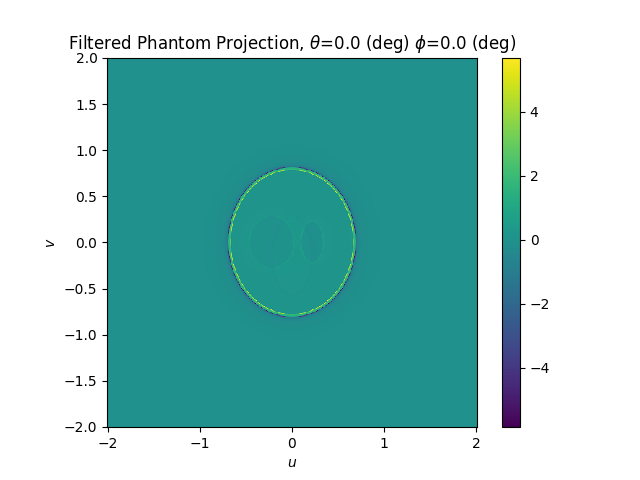

In [19]:
fig, ax = plt.subplots()
im = grid_uv.plot(ax, p_uv_filtered)
ax.set_xlabel(f'$u$')
ax.set_ylabel(f'$v$')
ax.set_title(f'Filtered Phantom Projection, $\\theta$={theta.deg} (deg) $\phi$={phi.deg} (deg)')
plt.colorbar(im, ax=ax);

In [20]:
X_backproject = backproject3(theta, phi, axes3, grid_uv, p_uv_filtered)

In [21]:
X_backproject_actor = axes3.actor(X_backproject)
#X_backproject_actor.GetProperty().SetOpacity(0.5)

In [22]:
ren = Renderer()
ren.add_actor(X_backproject_actor)
#ren.axes_on((-1, 1, -1, 1, -1, 1))
ren.axes_on((-1.5, 1.5, -1.5, 1.5, -1.5, 1.5))
ren.reset_camera()
#ren.start()

In [23]:
N_phi = 256
phi_axis = AngleRegularAxis.linspace(Angle(deg=0), Angle(deg=180), N_phi, endpoint=False)

In [24]:
sinogram3 = [p3.proj(theta, Angle(deg=phi_i.deg), grid_uv) for phi_i in phi_axis]

In [25]:
X_backproject = fbp3_theta0(axes3, grid_uv, phi_axis, sinogram3, theta0=theta)

  0%|          | 0/256 [00:00<?, ?it/s]

In [26]:
phi_axis.rad.T

0.01227184630308513

In [27]:
c_z, c_y, c_x = axes3.centers
p_xyz = np.array([c_x, c_y, c_z])

X_p3 = p3(*p_xyz.reshape(3, Nx * Ny * Nz))
X_p3.shape = axes3.shape

In [28]:
k_mid = Nz // 2
grid_xy = RegularGrid(axes3.axis_x, axes3.axis_y)

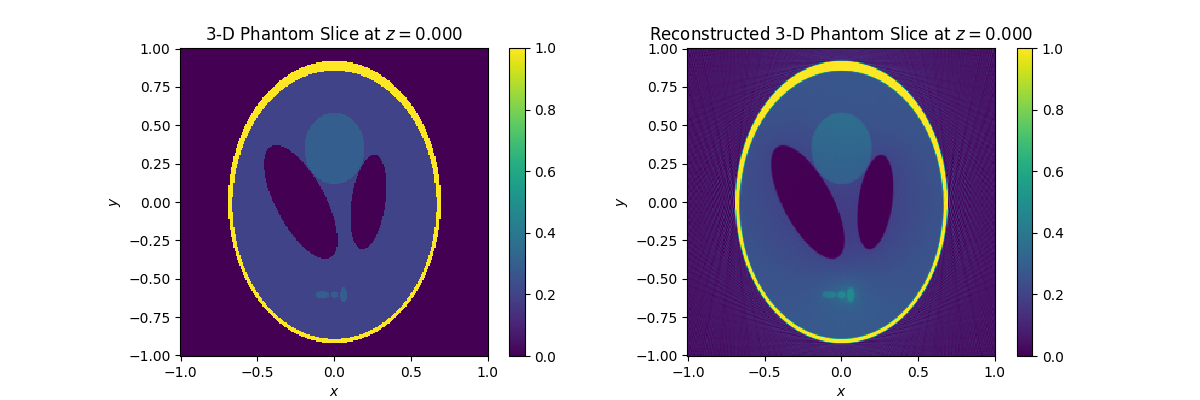

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
im0 = grid_xy.plot(ax[0], X_p3[k_mid, :, :])
ax[0].set_xlabel(f'$x$')
ax[0].set_ylabel(f'$y$')
ax[0].set_title(f'3-D Phantom Slice at $z=${axes3.axis_z[k_mid]:.3f}')
plt.colorbar(im0, ax=ax[0])
#im1 = grid_xy.plot(ax[1], X_backproject[k_mid, :, :])
im1 = grid_xy.plot(ax[1], X_backproject[k_mid, :, :], vmin=0, vmax=1)
ax[1].set_xlabel(f'$x$')
ax[1].set_ylabel(f'$y$')
ax[1].set_title(f'Reconstructed 3-D Phantom Slice at $z=${axes3.axis_z[k_mid]:.3f}')
plt.colorbar(im1, ax=ax[1]);

In [30]:
j_mid = Ny // 2
grid_xz = RegularGrid(axes3.axis_x, axes3.axis_z)

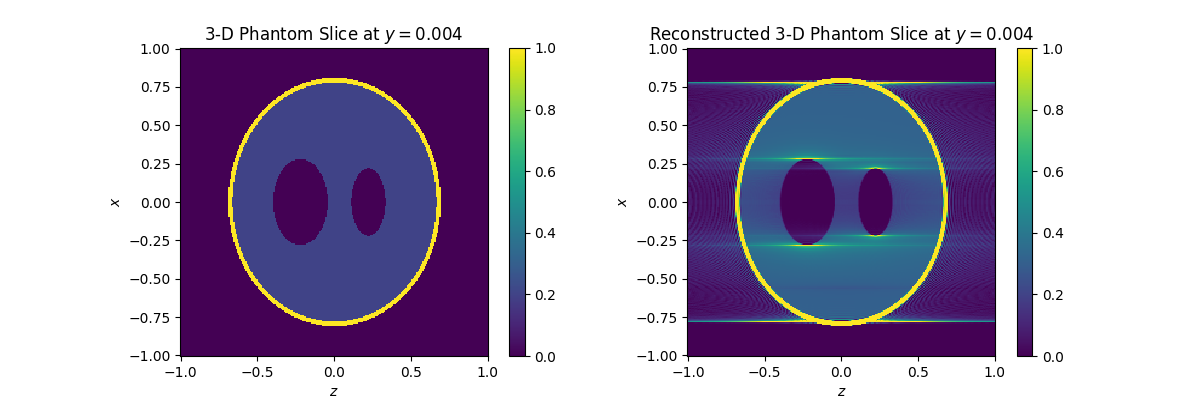

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
im0 = grid_xz.plot(ax[0], X_p3[:, j_mid, :])
ax[0].set_xlabel(f'$z$')
ax[0].set_ylabel(f'$x$')
ax[0].set_title(f'3-D Phantom Slice at $y=${axes3.axis_y[j_mid]:.3f}')
plt.colorbar(im0, ax=ax[0])
#im1 = grid_xz.plot(ax[1], X_backproject[:, j_mid, :])
im1 = grid_xz.plot(ax[1], X_backproject[:, j_mid, :], vmin=0, vmax=1)
ax[1].set_xlabel(f'$z$')
ax[1].set_ylabel(f'$x$')
ax[1].set_title(f'Reconstructed 3-D Phantom Slice at $y=${axes3.axis_y[j_mid]:.3f}')
plt.colorbar(im1, ax=ax[1]);

In [32]:
i_mid = Nx // 2
grid_zy = RegularGrid(axes3.axis_y, axes3.axis_z)

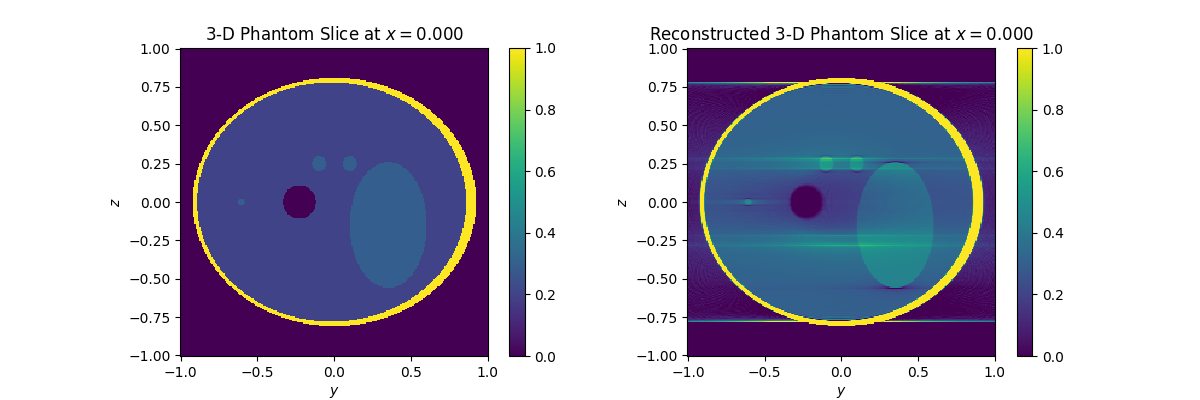

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
im0 = grid_zy.plot(ax[0], X_p3[:, :, i_mid])
ax[0].set_xlabel(f'$y$')
ax[0].set_ylabel(f'$z$')
ax[0].set_title(f'3-D Phantom Slice at $x=${axes3.axis_x[i_mid]:.3f}')
plt.colorbar(im0, ax=ax[0])
#im1 = grid_zy.plot(ax[1], X_backproject[:, :, i_mid])
im1 = grid_zy.plot(ax[1], X_backproject[:, :, i_mid], vmin=0, vmax=1)
ax[1].set_xlabel(f'$y$')
ax[1].set_ylabel(f'$z$')
ax[1].set_title(f'Reconstructed 3-D Phantom Slice at $x=${axes3.axis_x[i_mid]:.3f}')
plt.colorbar(im1, ax=ax[1]);

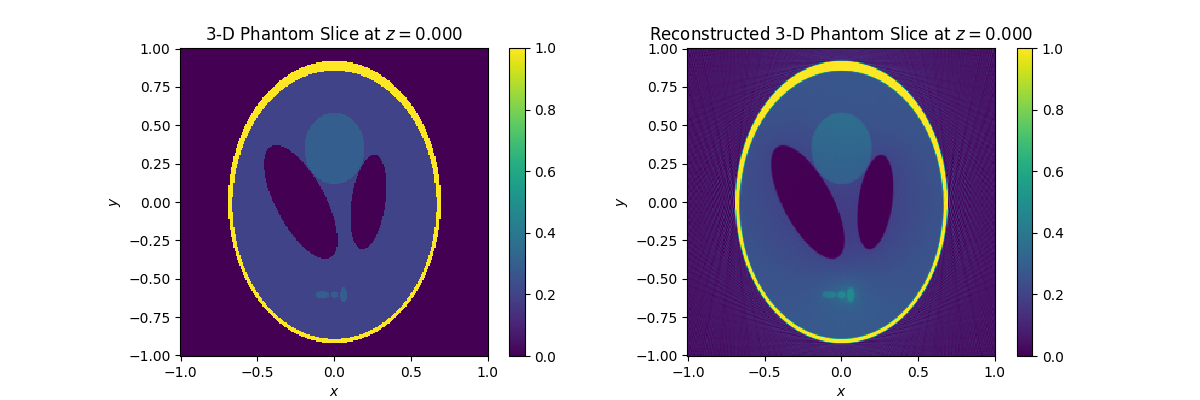

In [34]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
im0 = grid_xy.plot(ax[0], X_p3[k_mid, :, :])
ax[0].set_xlabel(f'$x$')
ax[0].set_ylabel(f'$y$')
ax[0].set_title(f'3-D Phantom Slice at $z=${axes3.axis_z[k_mid]:.3f}')
plt.colorbar(im0, ax=ax[0])
im1 = grid_xy.plot(ax[1], X_backproject[k_mid, :, :], vmin=0, vmax=1)
ax[1].set_xlabel(f'$x$')
ax[1].set_ylabel(f'$y$')
ax[1].set_title(f'Reconstructed 3-D Phantom Slice at $z=${axes3.axis_z[k_mid]:.3f}')
plt.colorbar(im1, ax=ax[1]);

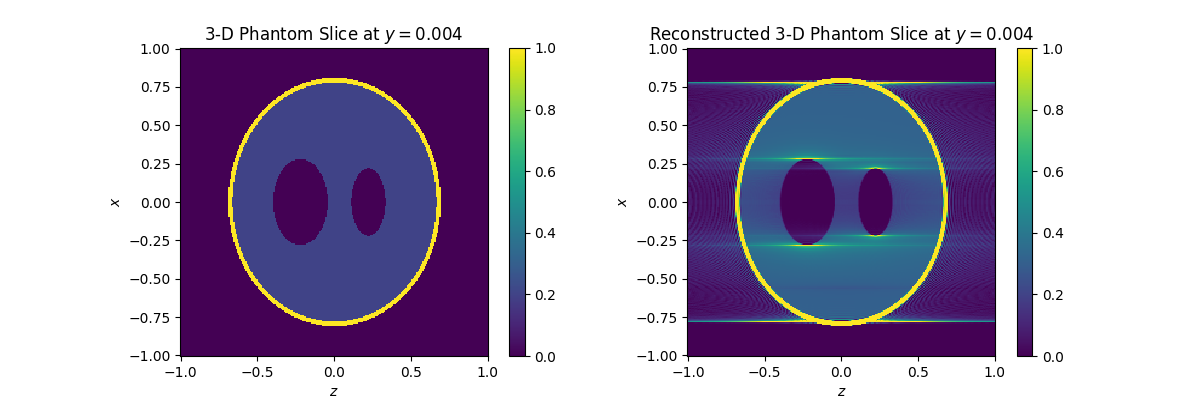

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
im0 = grid_xz.plot(ax[0], X_p3[:, j_mid, :])
ax[0].set_xlabel(f'$z$')
ax[0].set_ylabel(f'$x$')
ax[0].set_title(f'3-D Phantom Slice at $y=${axes3.axis_y[j_mid]:.3f}')
plt.colorbar(im0, ax=ax[0])
im1 = grid_xz.plot(ax[1], X_backproject[:, j_mid, :], vmin=0, vmax=1)
ax[1].set_xlabel(f'$z$')
ax[1].set_ylabel(f'$x$')
ax[1].set_title(f'Reconstructed 3-D Phantom Slice at $y=${axes3.axis_y[j_mid]:.3f}')
plt.colorbar(im1, ax=ax[1]);

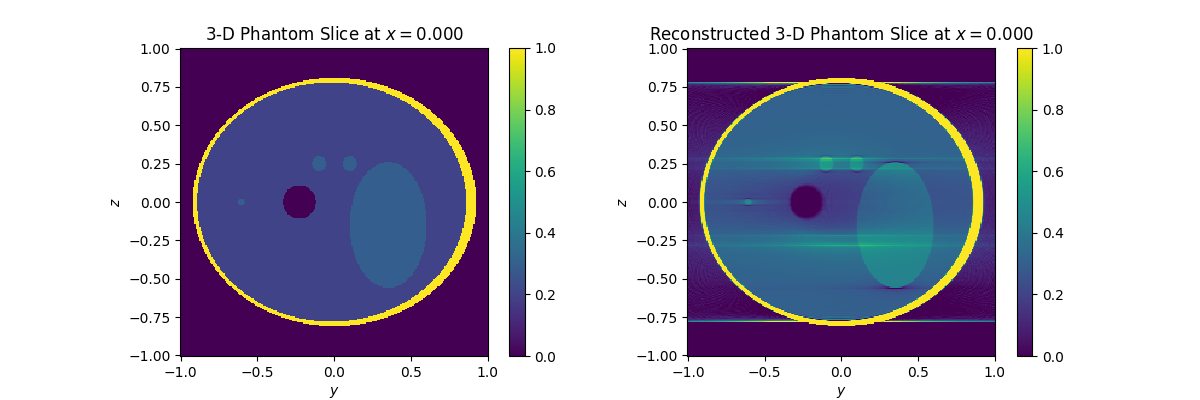

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
im0 = grid_zy.plot(ax[0], X_p3[:, :, i_mid])
ax[0].set_xlabel(f'$y$')
ax[0].set_ylabel(f'$z$')
ax[0].set_title(f'3-D Phantom Slice at $x=${axes3.axis_x[i_mid]:.3f}')
plt.colorbar(im0, ax=ax[0])
im1 = grid_zy.plot(ax[1], X_backproject[:, :, i_mid], vmin=0, vmax=1)
ax[1].set_xlabel(f'$y$')
ax[1].set_ylabel(f'$z$')
ax[1].set_title(f'Reconstructed 3-D Phantom Slice at $x=${axes3.axis_x[i_mid]:.3f}')
plt.colorbar(im1, ax=ax[1]);